Repository link: https://github.com/ryangreen6/Geospatial-Analysis-RG

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats
import pandas as pd

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


In [2]:
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')
cat_df = catalog.df

# Homework 2: Geospatial Analysis

For this assignment I chose to use the models FGOALS-g3 and MIROC6. FGOALS-g3 is a Chinese model, and MIROC6 is a Japanese model. China has a history of underreporting statistics related to climate change, so I was curious to see if these models would differ, being neighboring nations and having vastly different governments and priorities. 

I also chose SSP370 for this assignment, as the current political climate shows a rise of nationalism around the world, and I can only assume that this would result in higher emissions and reliance on traditional fossil fuels. 

For the region, I chose East Asia, covering the extents of both Japan and China. 


## Model 1: FGOALS-g3

In [3]:
goals = catalog.search(activity_id = ['ScenarioMIP', 'CMIP'], 
                     source_id = ['FGOALS-g3'], 
                     experiment_id = ['historical', 'ssp370'], 
                     member_id = 'r1i1p1f1', 
                     table_id = 'Amon', 
                     variable_id = 'tas')

goalsdf = goals.df

# FGOALS-g3 historical
goals_histdf = goalsdf[(goalsdf["source_id"] == 'FGOALS-g3') & (goalsdf["experiment_id"] == "historical")]

# FGOALS-g3 SSP370
goals_sspdf = goalsdf[(goalsdf["source_id"] == 'FGOALS-g3') & (goalsdf["experiment_id"] == "ssp370")]

In [4]:
hist_data = xr.open_zarr(goals_histdf['zstore'][0], storage_options={'anon': True})
hist_data['time'] = hist_data.time.astype('datetime64[ns]')
hist_data = hist_data.sel(time = slice('1850-01-01', '2014-12-31'))

In [5]:
ssp_data = xr.open_zarr(goals_sspdf['zstore'][1], storage_options={'anon': True})
ssp_data['time'] = ssp_data.time.astype('datetime64[ns]')

In [6]:
goals_data = xr.concat([hist_data, ssp_data], dim="time")

In [7]:
temp_data = goals_data.tas
temp_data = temp_data - 273.15

In [8]:
goals_early = temp_data.sel(time=slice("1850-01-01", "1870-12-31"))
goals_late = temp_data.sel(time=slice("2000-01-01", "2020-12-15"))

goals_early_mn = goals_early.mean(dim="time")
goals_late_mn = goals_late.mean(dim="time")

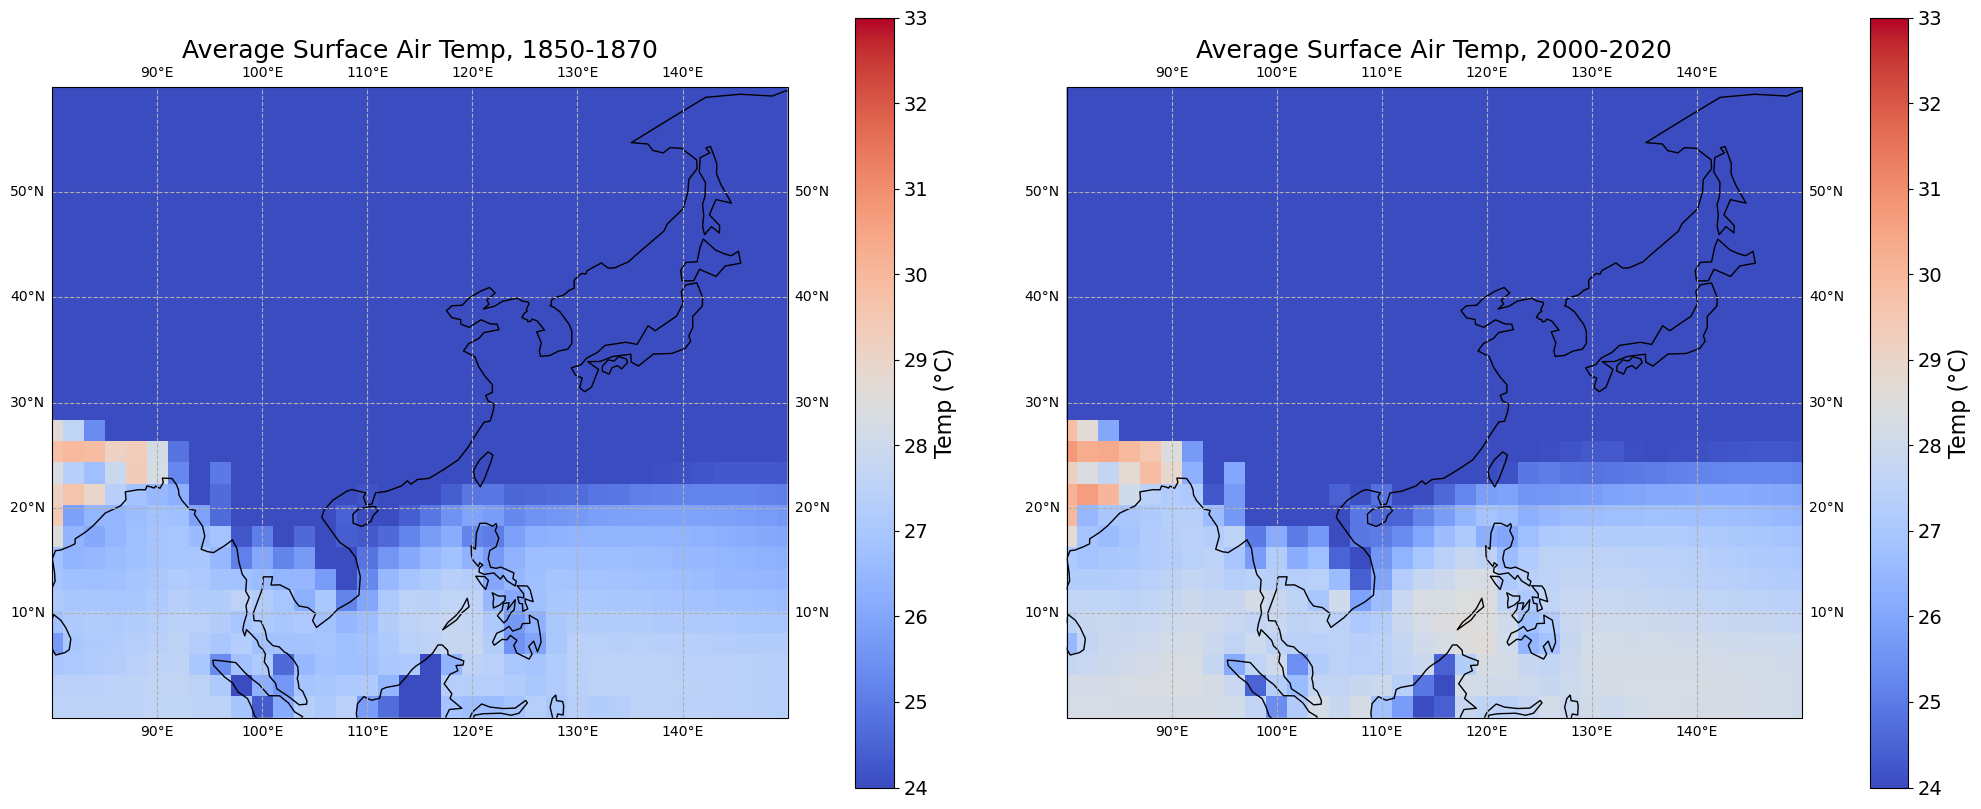

In [9]:
# Define projection
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Plot using pcolormesh
plot1 = axes[0].pcolormesh(
    goals_early_mn.lon.values, goals_early_mn.lat.values, goals_early_mn.values,
    transform=map,
    cmap="coolwarm",
    vmin=24,
    vmax=33
)

# Add title
axes[0].set_title("Average Surface Air Temp, 1850-1870", fontsize=18)

axes[0].xlabel_style = {'size': 16}
axes[0].ylabel_style = {'size': 16}

# Set the extent
axes[0].set_extent([80, 150, 0, 60], crs=ccrs.PlateCarree())
axes[0].add_feature(cfeature.COASTLINE)
axes[0].gridlines(draw_labels=True, linestyle= "--")

cbar1 = fig.colorbar(
    plot1, ax=axes[0],
    orientation="vertical", fraction=0.05, pad=0.08
)
cbar1.set_label("Temp (°C)", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
cbar1.ax.xaxis.set_label_position('top')

# Plot using pcolormesh
plot2 = axes[1].pcolormesh(
    goals_late_mn.lon.values, goals_late_mn.lat.values, goals_late_mn.values,
    transform=map,
    cmap="coolwarm",
    vmin=24,
    vmax=33
)

# Add title
axes[1].set_title("Average Surface Air Temp, 2000-2020", fontsize=18)

axes[1].xlabel_style = {'size': 16}
axes[1].ylabel_style = {'size': 16}

# Set the extent
axes[1].set_extent([80, 150, 0, 60], crs=ccrs.PlateCarree())
axes[1].add_feature(cfeature.COASTLINE)
axes[1].gridlines(draw_labels=True, linestyle= "--")

cbar2 = fig.colorbar(
    plot2, ax=axes[1],
    orientation="vertical", fraction=0.05, pad=0.08
)
cbar2.set_label("Temp (°C)", fontsize=16)
cbar2.ax.tick_params(labelsize=14)
cbar2.ax.xaxis.set_label_position('top')

In [10]:
# Change

diff = goals_late_mn.values - goals_early_mn.values
diff_norm = (diff - diff.min()) / (diff.max() - diff.min())

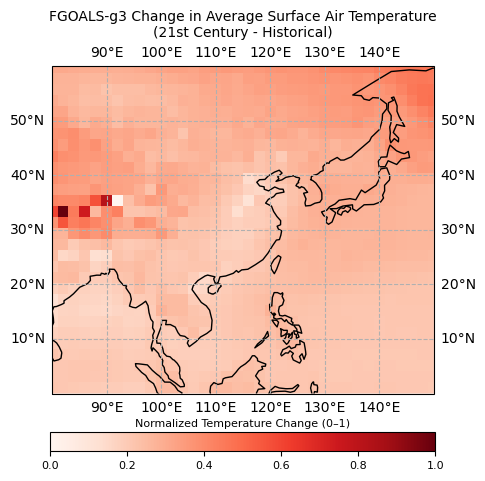

In [11]:
map = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": map})

plot = ax.pcolormesh(
    goals_late_mn.lon, goals_late_mn.lat, diff_norm,
    transform=map, 
    cmap="Reds",
    vmin=0, 
    vmax=1
)

ax.set_title("FGOALS-g3 Change in Average Surface Air Temperature\n(21st Century - Historical)", fontsize=10)
ax.set_extent([80, 150, 0, 60], crs=map)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, linestyle="--")

cbar = plt.colorbar(plot, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Normalized Temperature Change (0–1)", fontsize=8)
cbar.ax.tick_params(labelsize=8)
cbar.ax.xaxis.set_label_position('top')

## Model 2: MIROC6

In [12]:
mir = catalog.search(activity_id = ['ScenarioMIP', 'CMIP'], 
                     source_id = ['MIROC6'], 
                     experiment_id = ['historical', 'ssp370'], 
                     member_id = 'r1i1p1f1', 
                     table_id = 'Amon', 
                     variable_id = 'tas')

mirdf = mir.df

# FGOALS-g3 historical
mir_histdf = mirdf[(mirdf["source_id"] == 'MIROC6') & (mirdf["experiment_id"] == "historical")]

# FGOALS-g3 SSP370
mir_sspdf = mirdf[(mirdf["source_id"] == 'MIROC6') & (mirdf["experiment_id"] == "ssp370")]

In [13]:
hist_data = xr.open_zarr(mir_histdf['zstore'][0], storage_options={'anon': True})
hist_data['time'] = hist_data.time.astype('datetime64[ns]')
hist_data = hist_data.sel(time = slice('1850-01-01', '2014-12-31'))

In [14]:
ssp_data = xr.open_zarr(mir_sspdf['zstore'][1], storage_options={'anon': True})
ssp_data['time'] = ssp_data.time.astype('datetime64[ns]')

In [15]:
mir_data = xr.concat([hist_data, ssp_data], dim="time")

In [16]:
temp_data = mir_data.tas
temp_data = temp_data - 273.15

In [17]:
mir_early = temp_data.sel(time=slice("1850-01-01", "1870-12-31"))
mir_late = temp_data.sel(time=slice("2000-01-01", "2020-12-15"))

mir_early_mn = mir_early.mean(dim="time")
mir_late_mn = mir_late.mean(dim="time")

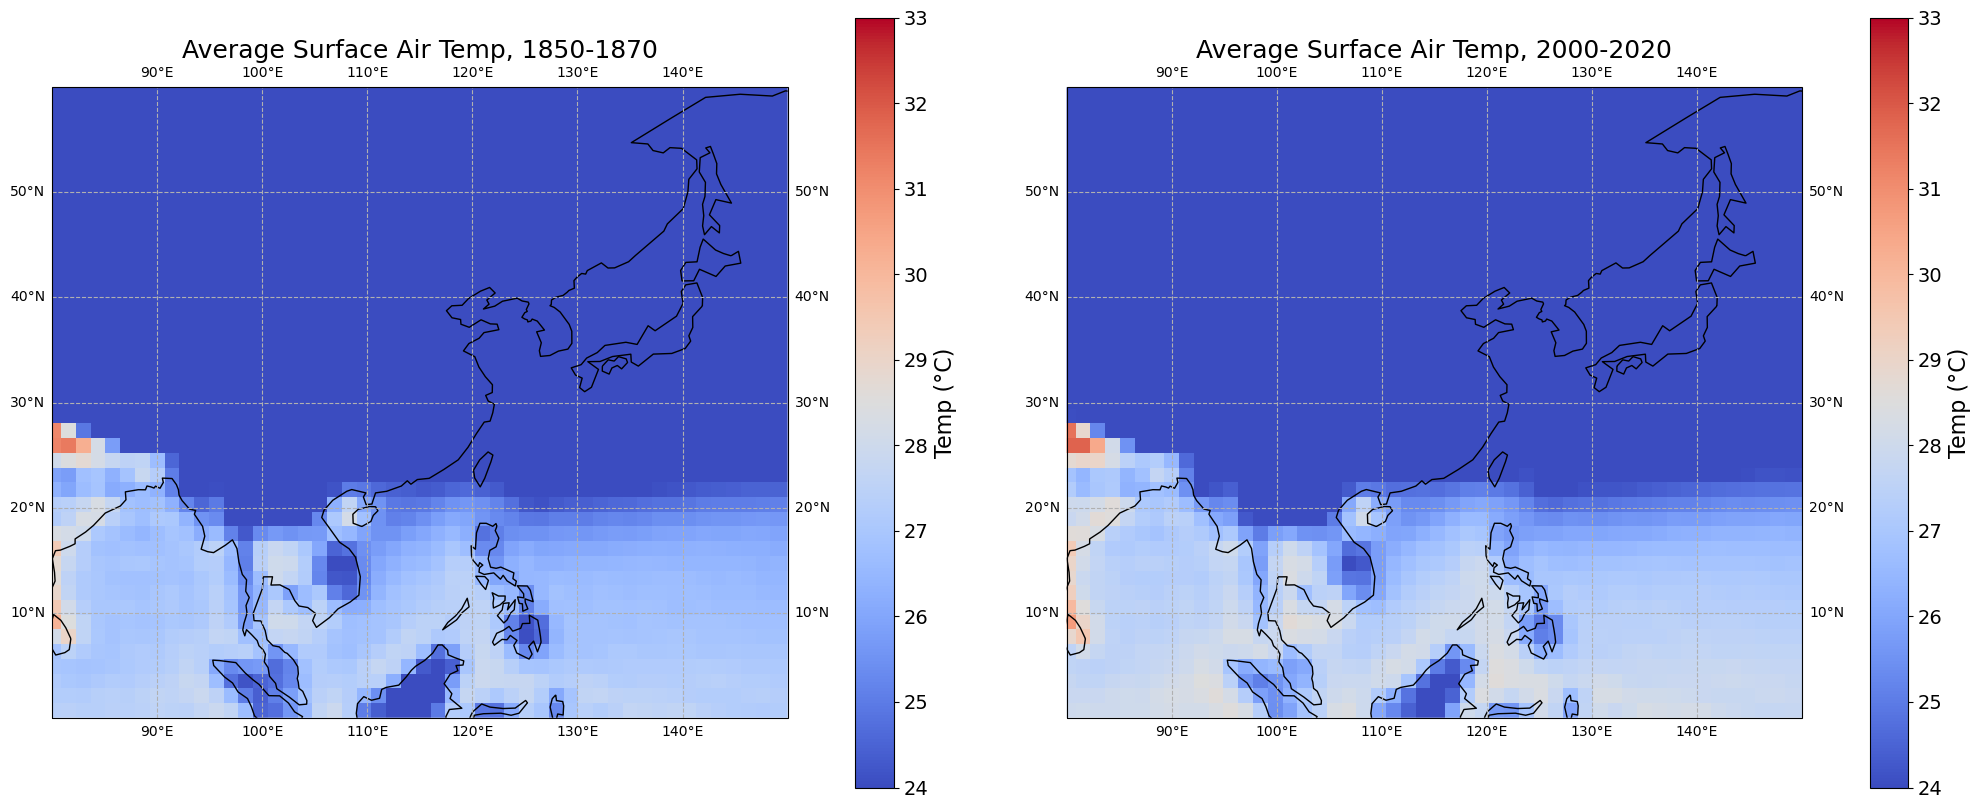

In [18]:
# Define projection
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Plot using pcolormesh
plot1 = axes[0].pcolormesh(
    mir_early_mn.lon.values, mir_early_mn.lat.values, mir_early_mn.values,
    transform=map,
    cmap="coolwarm",
    vmin=24,
    vmax=33
)

# Add title
axes[0].set_title("Average Surface Air Temp, 1850-1870", fontsize=18)

axes[0].xlabel_style = {'size': 16}
axes[0].ylabel_style = {'size': 16}

# Set the extent
axes[0].set_extent([80, 150, 0, 60], crs=ccrs.PlateCarree())
axes[0].add_feature(cfeature.COASTLINE)
axes[0].gridlines(draw_labels=True, linestyle= "--")

cbar1 = fig.colorbar(
    plot1, ax=axes[0],
    orientation="vertical", fraction=0.05, pad=0.08
)
cbar1.set_label("Temp (°C)", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
cbar1.ax.xaxis.set_label_position('top')

# Plot using pcolormesh
plot2 = axes[1].pcolormesh(
    mir_late_mn.lon.values, mir_late_mn.lat.values, mir_late_mn.values,
    transform=map,
    cmap="coolwarm",
    vmin=24,
    vmax=33
)

# Add title
axes[1].set_title("Average Surface Air Temp, 2000-2020", fontsize=18)

axes[1].xlabel_style = {'size': 16}
axes[1].ylabel_style = {'size': 16}

# Set the extent
axes[1].set_extent([80, 150, 0, 60], crs=ccrs.PlateCarree())
axes[1].add_feature(cfeature.COASTLINE)
axes[1].gridlines(draw_labels=True, linestyle= "--")

cbar2 = fig.colorbar(
    plot2, ax=axes[1],
    orientation="vertical", fraction=0.05, pad=0.08
)
cbar2.set_label("Temp (°C)", fontsize=16)
cbar2.ax.tick_params(labelsize=14)
cbar2.ax.xaxis.set_label_position('top')

In [19]:
# Change

diff = mir_late_mn.values - mir_early_mn.values
diff_norm1 = (diff - diff.min()) / (diff.max() - diff.min())

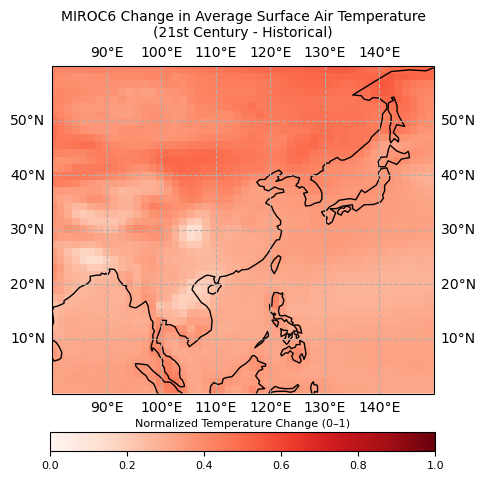

In [20]:
map = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": map})

plot = ax.pcolormesh(
    mir_late_mn.lon, mir_late_mn.lat, diff_norm1,
    transform=map, 
    cmap="Reds",
    vmin=0, 
    vmax=1
)

ax.set_title("MIROC6 Change in Average Surface Air Temperature\n(21st Century - Historical)", fontsize=10)
ax.set_extent([80, 150, 0, 60], crs=map)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True, linestyle="--")

cbar = plt.colorbar(plot, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Normalized Temperature Change (0–1)", fontsize=8)
cbar.ax.tick_params(labelsize=8)
cbar.ax.xaxis.set_label_position('top')

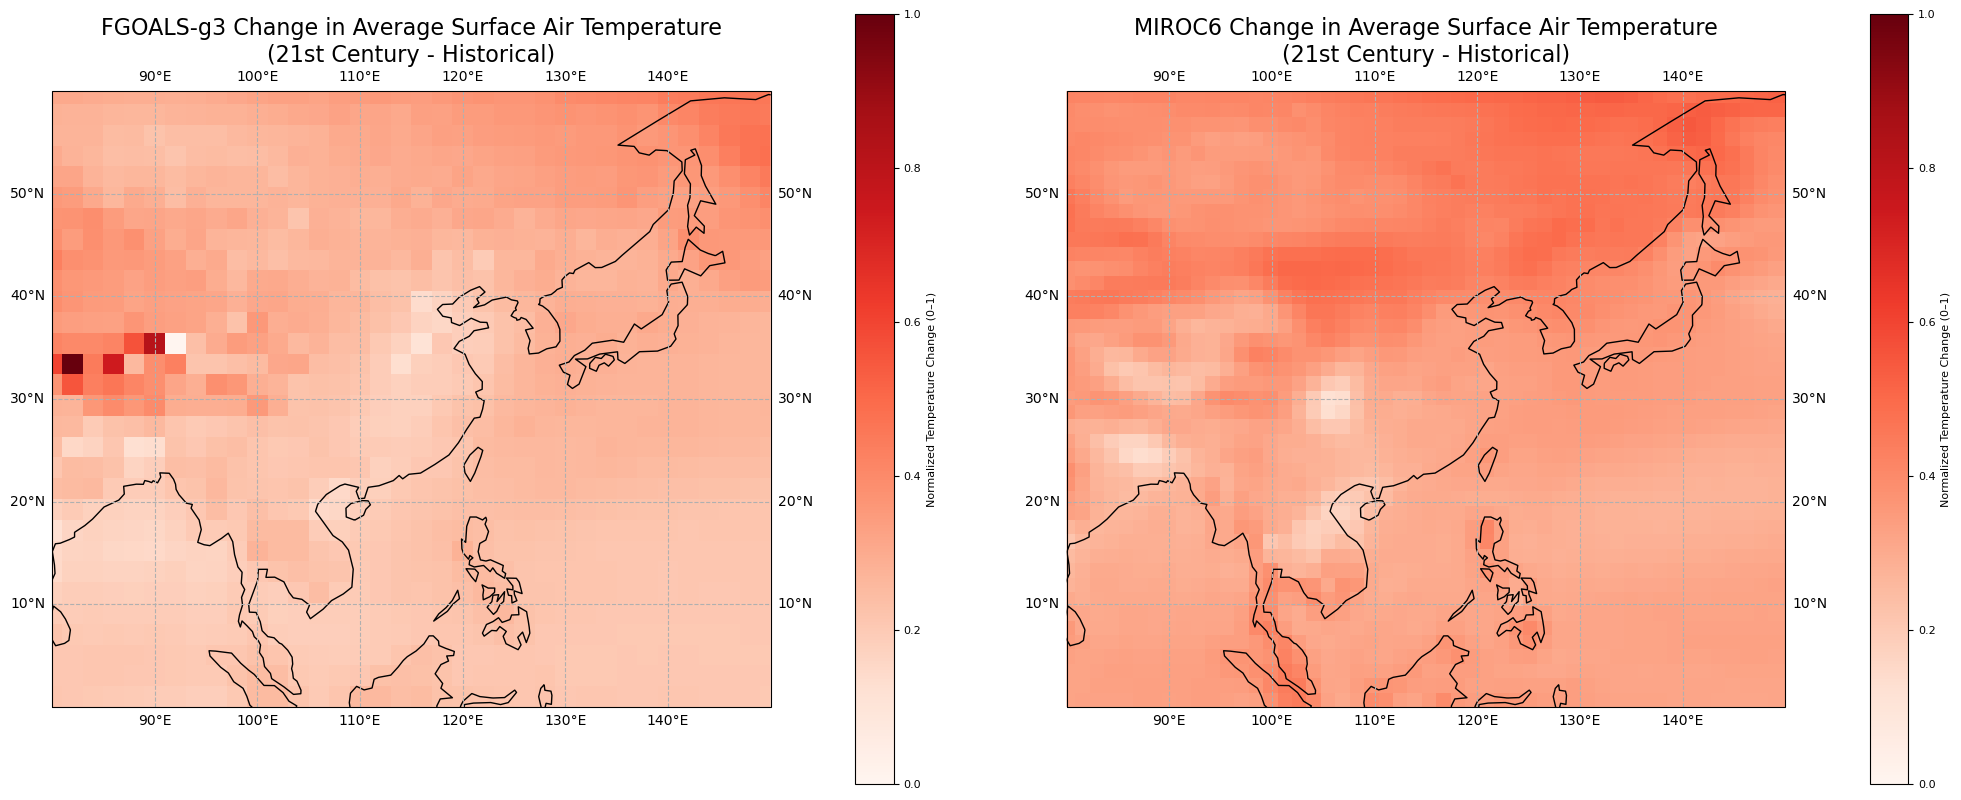

In [21]:
# Define projection
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

plot1 = axes[0].pcolormesh(
    goals_late_mn.lon, goals_late_mn.lat, diff_norm,
    transform=map, 
    cmap="Reds",
    vmin=0, 
    vmax=1
)

axes[0].set_title("FGOALS-g3 Change in Average Surface Air Temperature\n(21st Century - Historical)", fontsize=16)
axes[0].set_extent([80, 150, 0, 60], crs=map)
axes[0].add_feature(cfeature.COASTLINE)
axes[0].gridlines(draw_labels=True, linestyle="--")

cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', fraction=0.05, pad=0.1)
cbar1.set_label("Normalized Temperature Change (0–1)", fontsize=8)
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.xaxis.set_label_position('top')

plot2 = axes[1].pcolormesh(
    mir_late_mn.lon, mir_late_mn.lat, diff_norm1,
    transform=map, 
    cmap="Reds",
    vmin=0, 
    vmax=1
)

axes[1].set_title("MIROC6 Change in Average Surface Air Temperature\n(21st Century - Historical)", fontsize=16)
axes[1].set_extent([80, 150, 0, 60], crs=map)
axes[1].add_feature(cfeature.COASTLINE)
axes[1].gridlines(draw_labels=True, linestyle="--")

cbar2 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', fraction=0.05, pad=0.1)
cbar2.set_label("Normalized Temperature Change (0–1)", fontsize=8)
cbar2.ax.tick_params(labelsize=8)
cbar2.ax.xaxis.set_label_position('top')

These maps show the difference in average surface air temperature between 1850–1870 and 2000–2020 over East Asia, from a Chinese model (FGOALS-g3) and a Japanese model (MIROC6). The Chinese-run FGOALS-g3 yields very strong warming concentrated over the Himalayas, whereas the Japanese-run MIROC6 predicts more widespread increases across northern China, the Philippines, and the Russian far east. Because both plots use the same baseline and recent periods, the different spatial patterns might imply that each modeling system’s origin country may shape where and how much warming is measured. 

Both China and Japan industrialized much later than counties in Europe. Japan industrialized during the Meiji Era (1868-1912), which was a total reversal of their previously feudal society. China took another forty years, industrializing under Mao's 'Five Year Plan' in 1953. I chose the time periods 1850-1870 and 2000-2020 to hopefully show long term anthropogenic change. 

Regardless, the vast differences in these models' temperature readings indicate that communities in East Asia, while adapting to climate change, should draw from multiple climate models to better understand their risk. 